In [7]:
# https://drive.google.com/file/d/1xKJlWIbfSrPw6wvdFTBdaoStAyWjoqz8/view?usp=sharing
import gdown
file_id = '1xKJlWIbfSrPw6wvdFTBdaoStAyWjoqz8'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'KorSTS.zip', quiet=False)
!unzip KorSTS.zip

Downloading...
From: https://drive.google.com/uc?id=1xKJlWIbfSrPw6wvdFTBdaoStAyWjoqz8
To: /content/KorSTS.zip
100%|██████████| 438k/438k [00:00<00:00, 7.53MB/s]

Archive:  KorSTS.zip
  inflating: sts-test.tsv            
  inflating: sts-dev.tsv             
  inflating: sts-train.tsv           


In [8]:
!pip install gluonnlp mxnet
# !pip install python==3.8.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.9 MB/s eta 0:00:00
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661659 sha256=cd2be31ba37f57ea4347335b61bc0f7095e7b62646ecba0833fbe4062e18ef84
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
# from gluonnlp.data import SentencepieceTokenizer

In [10]:
# BERT 모델
# 1. 양방향 학습... MASK 처리 해서 마스킹 된 단어를 예측 -> 다양한 위치에서 문맥정보를 학습
# 2. NSP(Next Sentence Prediction) : 두개의 문장을 입력으로 받음.
# 첫번째 문장과 두번째 문장 비교

In [11]:
train_data = pd.read_csv('sts-train.tsv', sep='\t', quoting=3)
test_data = pd.read_csv('sts-test.tsv', sep='\t', quoting=3)

In [12]:
train_data

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
...,...,...,...,...,...,...,...
5744,main-news,headlines,2016,1456,0.00,폭풍우 클로다흐가 영국을 강타하면서 심한 강풍,메르켈은 나토와 라트비아의 연대를 약속한다.
5745,main-news,headlines,2016,1465,0.00,리비아 테러리스트들이 공습에 대한 복수로 찍은 수십 명의 이집트 인질들,나일강에서 더 많은 시체가 발견되면서 이집트 보트 충돌 사고 사망자 수가 증가한다.
5746,main-news,headlines,2016,1466,0.00,바레인으로 향하는 대통령,시 주석 : 에볼라 퇴치를 계속 돕기 위한 중국
5747,main-news,headlines,2016,1470,0.00,"중국, 인도는 양국 관계를 증진시키겠다고 맹세한다",중국은 불안한 주식 거래자들을 안심시키기 위해 뒤뚱거리고 있다.


In [13]:
train_data.shape

(5749, 7)

In [14]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.apply(lambda x: True if type(x) is not str else False).value_counts(), train_set.shape

(False    11498
 Name: count, dtype: int64,
 (11498,))

In [15]:
# 결측치와 중복 제거
print(f'중복데이터 : {train_set.duplicated().sum()}')
print(f'결측치 : {train_set.isnull().sum()}')
print(f'전체데이터 개수 : {train_set.shape[0]}')
train_set = train_set.dropna().drop_duplicates()
print(f'전처리 후 데이터 개수 : {train_set.shape[0]}')

중복데이터 : 1115
결측치 : 0
전체데이터 개수 : 11498
전처리 후 데이터 개수 : 10383


In [16]:
train_set.reset_index(drop=True, inplace=True)

In [17]:
train_set

,0
0,비행기가 이륙하고 있다.
1,한 남자가 큰 플루트를 연주하고 있다.
2,한 남자가 피자에 치즈를 뿌려놓고 있다.
3,세 남자가 체스를 하고 있다.
4,한 남자가 첼로를 연주하고 있다.
...,...
10378,메르켈은 나토와 라트비아의 연대를 약속한다.
10379,나일강에서 더 많은 시체가 발견되면서 이집트 보트 충돌 사고 사망자 수가 증가한다.
10380,시 주석 : 에볼라 퇴치를 계속 돕기 위한 중국
10381,중국은 불안한 주식 거래자들을 안심시키기 위해 뒤뚱거리고 있다.


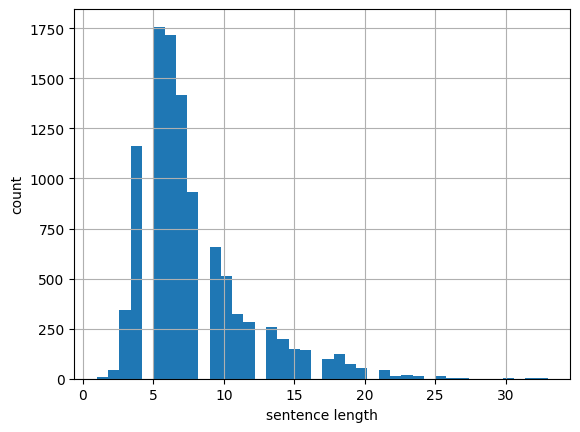

In [18]:
train_set.apply(lambda x : len(x.split())).hist(bins=40)
plt.xlabel('sentence length')
plt.ylabel('count')
plt.show()

In [19]:
# 사분위수
train_set.apply(lambda x : len(x.split())).describe()

,0
count,10383.000000
mean,7.717904
std,3.921041
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,33.000000


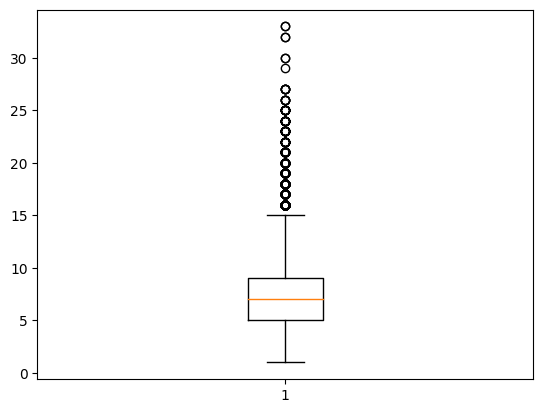

In [20]:
plt.boxplot(train_set.apply(lambda x : len(x.split())))
plt.show()

In [21]:
# BERT 관련 토크나이저를 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
#  토큰을 적용한 후의 각 문장의 토큰들의 길이
# 4분위수
train_set.apply(lambda x : len(tokenizer.tokenize(x))).describe()

,0
count,10383.000000
mean,19.370606
std,10.275411
min,2.000000
25%,12.000000
50%,16.000000
75%,23.000000
max,102.000000


<Axes: >

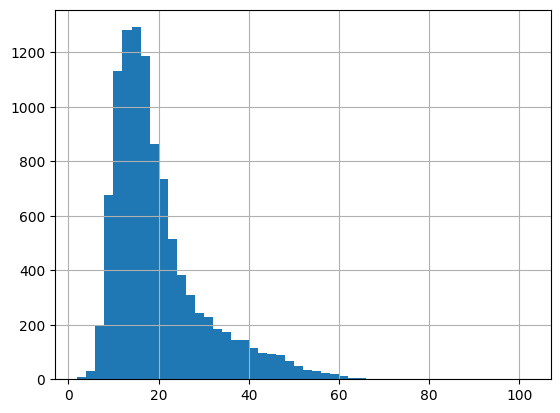

In [23]:
train_set.apply(lambda x : len(tokenizer.tokenize(x))).hist(bins=50)

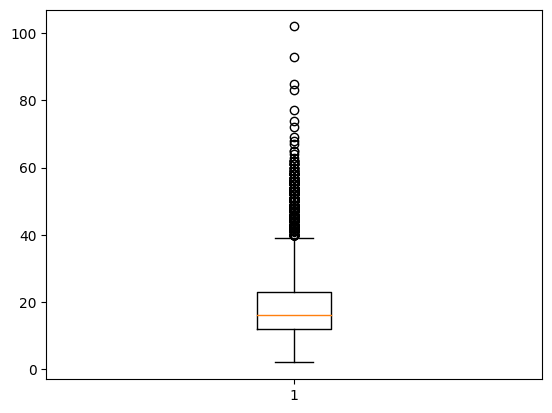

In [24]:
plt.boxplot(train_set.apply(lambda x : len(tokenizer.tokenize(x))))
plt.show()

In [25]:
train_bert_tokenizer_counts = train_set.apply(lambda x : len(tokenizer.tokenize(x)))

In [26]:
p_85 = np.percentile(train_bert_tokenizer_counts, 85)
p_90 = np.percentile(train_bert_tokenizer_counts, 90)
p_95 = np.percentile(train_bert_tokenizer_counts, 95)
p_85, p_90, p_95

(29.0, 34.0, 42.0)

In [27]:
# 사전학습 모델 로드
from transformers import TFBertModel
import tensorflow as tf

In [28]:
help(BertTokenizer.from_pretrained)

Help on method from_pretrained in module transformers.tokenization_utils_base:

from_pretrained(pretrained_model_name_or_path: Union[str, os.PathLike], *init_inputs, cache_dir: Union[str, os.PathLike, NoneType] = None, force_download: bool = False, local_files_only: bool = False, token: Union[bool, str, NoneType] = None, revision: str = 'main', trust_remote_code=False, **kwargs) method of builtins.type instance
    Instantiate a [`~tokenization_utils_base.PreTrainedTokenizerBase`] (or a derived class) from a predefined
    tokenizer.
    
    Args:
        pretrained_model_name_or_path (`str` or `os.PathLike`):
            Can be either:
    
            - A string, the *model id* of a predefined tokenizer hosted inside a model repo on huggingface.co.
            - A path to a *directory* containing vocabulary files required by the tokenizer, for instance saved
              using the [`~tokenization_utils_base.PreTrainedTokenizerBase.save_pretrained`] method, e.g.,
              `./my

In [29]:
# 토크나이저 가져오기
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
# 하이퍼 파라미터 정의
BATCH_SIZE = 16
NUM_EPOCHS = 2
MAX_LEN = 42

In [31]:
tokenizer.all_special_tokens, tokenizer.all_special_ids # 시작 끝 패딩 없는값 마스크

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [100, 102, 0, 101, 103])

In [32]:
# Bert는 로드한 사전학습 Bert모델은 다국어
tokenizer.tokenize('안녕하세요'), tokenizer.tokenize('Hello world good morning')

(['안', '##녕', '##하', '##세', '##요'], ['Hello', 'world', 'good', 'morning'])

In [33]:
# 우리가 로드한 사전학습 Bert 모델은 다국어
kor_enc = tokenizer.tokenize('안녕하세요')
eng_enc = tokenizer.tokenize('Hello world good morning')
kor_enc, eng_enc

(['안', '##녕', '##하', '##세', '##요'], ['Hello', 'world', 'good', 'morning'])

In [34]:
tokenizer.convert_tokens_to_string(kor_enc), tokenizer.convert_tokens_to_string(eng_enc)

('안녕하세요', 'Hello world good morning')

In [35]:
kor_enc = tokenizer.convert_tokens_to_ids(kor_enc)
eng_enc = tokenizer.convert_tokens_to_ids(eng_enc)

In [36]:
kor_enc = tokenizer.encode('안녕하세요', add_special_tokens=True) # add_special_tokens=True 기본
eng_enc = tokenizer.encode('Hello world good morning')
kor_enc, eng_enc

([101, 9521, 118741, 35506, 24982, 48549, 102],
 [101, 31178, 11356, 15198, 28757, 102])

In [37]:
tokenizer.decode(kor_enc), tokenizer.decode(eng_enc)

('[CLS] 안녕하세요 [SEP]', '[CLS] Hello world good morning [SEP]')

In [38]:
# 두개의 문장을 입력으로 받아서 Bert 모델에 맞게 인코딩
def bert_tokenizer(sent1, sent2, MAX_LEN):
    # 인코딩
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN, # Pad & truncate all sentences.
        # pad_to_max_length = True,
        padding = 'max_length',
        return_attention_mask = True, # Construct attn. masks.
        truncation=True
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id

In [39]:
# 특수문자 제거 - 정규식
import re
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent) # 한글과 공백을 제외한 모든 문자는 제거
    return sent_clean

inputids = []
attention_masks = []
token_type_ids = []
data_labels = []

# 두개의 문장과 스코어를 Bert에 사전학습을 진행
# for sent1, sen2, score in zip(train_data['sentence1'], train_data['sentence2'], train_data['score'])
for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    input_id, attention_mask, token_type_id = bert_tokenizer(clean_text(sent1), clean_text(sent2), MAX_LEN)
    # 오리지널 데이터를 bert 토크나이저에 맞게 전처리 진행함
    inputids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    data_labels.append(score)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [40]:
assert np.mean([len(word) for word in inputids]) == MAX_LEN
train_input_ids = np.array(inputids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_token_type_ids = np.array(token_type_ids, dtype=int)
train_data_labels = np.array(data_labels)

In [41]:
# 동일한 방식으로 Dev 데이터 array 변환까지 시행
dev_data = pd.read_csv('sts-dev.tsv',sep='\t', quoting=3)
dev_data

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,0,5.00,안전모를 가진 한 남자가 춤을 추고 있다.,안전모를 쓴 한 남자가 춤을 추고 있다.
1,main-captions,MSRvid,2012test,2,4.75,어린아이가 말을 타고 있다.,아이가 말을 타고 있다.
2,main-captions,MSRvid,2012test,3,5.00,한 남자가 뱀에게 쥐를 먹이고 있다.,남자가 뱀에게 쥐를 먹이고 있다.
3,main-captions,MSRvid,2012test,7,2.40,한 여성이 기타를 연주하고 있다.,한 남자가 기타를 치고 있다.
4,main-captions,MSRvid,2012test,8,2.75,한 여성이 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
...,...,...,...,...,...,...,...
1495,main-news,headlines,2016,1283,2.00,과학자들은 화성에 물이 있다는 것을 증명한다,나사가 화성에서 물을 발견했습니까?
1496,main-news,headlines,2016,1434,0.00,프라나브는 국가별 평화를 위해 노력해야 한다고 강조한다.,"세계보건기구 : 인도, 선진국들의 행동을 후회하다"
1497,main-news,headlines,2016,1440,2.00,오염 스캔들로 인해 폭스바겐이 붉은색으로 미끄러졌다.,폭스바겐의 디젤 소유주들에 대한 호의의 제스처
1498,main-news,headlines,2016,1477,0.00,오바마가 옳다: 아프리카는 더 나은 리더십을 가질 자격이 있다,중기에 법무장관을 지명하기를 기다리는 오바마


In [42]:
dev_set = pd.Series(dev_data['sentence1'].tolist() + dev_data['sentence2'].tolist()).astype(str)
test_set = pd.Series(test_data['sentence1'].tolist() + test_data['sentence2'].tolist()).astype(str)
dev_set.apply(lambda x: True if type(x) is not str else False).value_counts(), dev_set.shape
test_set.apply(lambda x: True if type(x) is not str else False).value_counts(), test_set.shape
dev_set = dev_set.dropna().drop_duplicates()
test_set = test_set.dropna().drop_duplicates()
dev_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
dev_set, test_set

(0           안전모를 가진 한 남자가 춤을 추고 있다.
 1                   어린아이가 말을 타고 있다.
 2              한 남자가 뱀에게 쥐를 먹이고 있다.
 3                한 여성이 기타를 연주하고 있다.
 4               한 여성이 플루트를 연주하고 있다.
                    ...             
 2883            나사가 화성에서 물을 발견했습니까?
 2884    세계보건기구 : 인도, 선진국들의 행동을 후회하다
 2885      폭스바겐의 디젤 소유주들에 대한 호의의 제스처
 2886       중기에 법무장관을 지명하기를 기다리는 오바마
 2887          도끼 공격으로 중상을 입은 뉴욕 경찰관
 Length: 2888, dtype: object,
 0                             한 소녀가 머리를 스타일링하고 있다.
 1                          한 무리의 남자들이 해변에서 축구를 한다.
 2                          한 여성이 다른 여성의 발목을 재고 있다.
 3                                한 남자가 오이를 자르고 있다.
 4                               한 남자가 하프를 연주하고 있다.
                            ...                    
 2509                      필리핀은 여객선 침몰 후 100명을 구한다.
 2510                  팔레스타인인과 이스라엘 두 국가 해결안은 그림의 떡
 2511                       양측 의원들은 비밀경호국에 분노를 표출한다
 2512    미얀마는 일요일 투표를 위한 유권자 명단을 확정하기 위해 고군분투하고 있다.
 2513                          북한 대표단은 한국 관

In [43]:
assert np.mean([len(word) for word in inputids]) == MAX_LEN
dev_input_ids = np.array(inputids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_token_type_ids = np.array(token_type_ids, dtype=int)
dev_data_labels = np.array(data_labels)

In [44]:
len(train_data_labels), len(dev_data_labels)

(5749, 5749)

In [45]:
import gc
import tensorflow as tf
del train_data, dev_data
gc.collect()

0

In [46]:
# TF의 모델클래스를 상속받아서 Bert 모델의 회귀에 사용자 데이터를 적용한 클래스 생성
class TFBertForRegression(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class): # dir_path Bert의 캐시 경로
      super(TFBertForRegression.self).__init__()
      # Bert  모델 로드
      self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path, from_pt=True)
      self.num_class = num_class
      self.drop = tf.keras.layers.Dropout(0.5)
      self.regressor = tf.keras.layers.Dense(self, num_class, name='regressor',
                                             kernel_initializer=tf.keras.initializers.TruncatedNormal(self.config.initializer_range))
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): # training=False  학습용인지 여부
      # 모델 훈련
      outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids = token_type_ids)
      # [0] : Sequence Output : 모든 입력토큰에 대한 벡터 (기본 BERT 모델 기준 768차원)
      # 토큰 수준의 task에 사용(개체명 인식, 문장 분류 등)
      # [1] : Pooled Output : [CLS] 토큰에 해당하는 벡터... 문장수준의 task에 사용(문장 분류, 회귀 등)
      pooled_output = outputs[1] # 두번째 값을 저장 : 입력문장을 요약한 벡터
      polled_output = self.drop(pooled_output, training=training)
      logits = self.regressor(pooled_output) # 회귀, 음수도 나올 수 있음 (softmax를 통과하기 전)
      return logits


In [47]:
# 클래스 객체화
regression_model = TFBertForRegression
